# Phase histograms, different percentiles

## Import

In [1]:
import os 
os.chdir('/CSNG/studekat/ripple_band_project/code')

In [2]:
from functions_analysis import *
import pandas as pd
import numpy as np
import yaml
import pickle
import neo
import matplotlib.pyplot as plt

In [3]:
pd.set_option('mode.chained_assignment', None)

## Parameters

In [4]:
with open("/CSNG/studekat/ripple_band_project/code/params_analysis.yml") as f:
    params = yaml.safe_load(f)

DATA_FOLDER = params['data_folder'] ### folder with all the preprocessed data
DATES = params['dates']

DF_FOLDER = '/CSNG/studekat/ripple_band_project/dataframes' ### here the resulting dataframes will be saved
MONKEY_LIST = ['L','N','F','A']
AREAS_MERGED = params['areas_merged']
FINAL_CLASSES = params['final_classes']

In [5]:
with open("/CSNG/studekat/ripple_band_project/code/params_plotting.yml") as f:
    params_plot = yaml.safe_load(f)

CLASS_COLORS = params_plot['colors_class']

## Data loading

In [6]:
! pip install numpy==2.2.0

In [7]:
df_list = []
for monkey in MONKEY_LIST:
    print(monkey)
    all_RS_dates = params['dates'][monkey]['RS']
    for date in all_RS_dates:
        print(date)
        with open(f'{DF_FOLDER}/sua_prop_all/monkey{monkey}_all_arrays_date_{date}.pkl', "rb") as file:
             df_sua = pickle.load(file)
        df_list.append(df_sua)

df_merged = pd.concat(df_list,ignore_index=True)

L
20170725
20170809
20170810
N
20240719_B1
20240719_B2
F
20240122_B1
20241216_B1
A
20190815
20190816


In [8]:
a_list = []
for idx in df_merged.index:
    a = df_merged.loc[idx,'area']
    if a in ['V4','IT']:
        a_list.append(a)
    else:
        a_list.append('V12')

df_merged['area_merged'] = a_list

## Functions

In [9]:
def plot_phases_percentile(sua_df,phase_col_name,env_col_name,percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title='',y_max=0.3,n_bins=50,min_selectivity=0.1):
    """
    TODO

    Using spikes from the phase col, but the env. col for these spikes must be also provided.
    """
    
    num_areas = len(areas_list)
    num_cell_types = len(cell_types)

    ### only selecting subset of cells with high enough selectivity
    sua_df = sua_df[sua_df['norm_phase_sel_01_all_spikes']>min_selectivity]
    
    ### for each cell divide spikes into above and below env_th for a given percentile
    ### and append both lists into a correct row in sua_df (can be modified by this)
    th_env_name = f'env_th_perc_{percentile}'
    list_phase_high_lists = [] ### for each row of DF, there is a list of phases of spikes (resulting in list of lists/arrays)
    list_phase_low_lists = []
    for idx in sua_df.index:
        env_th = np.array(sua_df.loc[idx,th_env_name])
        phase_vector = np.array(sua_df.loc[idx,phase_col_name])
        env_vector = np.array(sua_df.loc[idx,env_col_name])
        mask = (env_vector>=env_th)
        phase_above = phase_vector[mask]
        phase_below = phase_vector[~mask]
        list_phase_high_lists.append(phase_above)
        list_phase_low_lists.append(phase_below)

    sua_df['high_RB_phases'] = list_phase_high_lists
    sua_df['low_RB_phases'] = list_phase_low_lists
    
    ### merging spikes into classes/area
    phases_high_pooled_area = {}
    phases_low_pooled_area = {}
    for area in areas_list:
        phases_high_pooled_area[area] = {}
        phases_low_pooled_area[area] = {}
        sua_area = sua_df[sua_df['area_merged']==area]
        for cl in cell_types:
            sua_cell_type = sua_area[sua_area['final_class']==cl]
            phases_high_lists = sua_cell_type['high_RB_phases'].values
            merged_high_phases_list = list_merge(phases_high_lists)   
            phases_high_pooled_area[area][cl] = merged_high_phases_list
            phases_low_lists = sua_cell_type['low_RB_phases'].values
            merged_low_phases_list = list_merge(phases_low_lists)   
            phases_low_pooled_area[area][cl] = merged_low_phases_list

    ### PLOTTING SPIKE PHASES ABOVE PERCENTILE TH.
    fig, ax = plt.subplots(1,num_areas)
    fig.set_figwidth(4*num_areas)
    fig.set_figheight(5)

    plt.suptitle(f'{title} \n Phase histograms (HIGH ENV.), perc. {percentile}')

    for area_idx in range(num_areas):
        ax[area_idx].set_title(areas_list[area_idx])
        area = areas_list[area_idx]
        for cell_idx in range(num_cell_types):
            cl = cell_types[cell_idx]
            #ax[area_idx].hist(phases_pooled_area[area][cl][::N],color=CLASS_COLORS[cl],alpha=0.8,density=True,bins=n_bins,histtype='step') #,label=cl)
            hist_values, bin_edges = np.histogram(phases_high_pooled_area[area][cl], bins=n_bins, density=True)
            ax[area_idx].step(bin_edges[:-1], hist_values, color=CLASS_COLORS[cl], where='mid',alpha=0.6)
            r, phi = circular_avg(phases_high_pooled_area[area][cl],bins=n_bins)
            ax[area_idx].axvline(phi,color=CLASS_COLORS[cl],alpha=0.6,ls='dashed',label=f'{cl}, R, Phi: {np.round(r,2), np.round(phi,2)}')
            ax[area_idx].spines['top'].set_visible(False)
            ax[area_idx].spines['right'].set_visible(False)
    
            ### plotting ripple band oscillation
            x_values = np.linspace(-np.pi, np.pi, 100)  # Generate 100 points from -π to π
            cos_values = (np.cos(x_values)+1)/7
            ax[area_idx].plot(x_values,cos_values,color='lightgray',alpha=0.5,ls='dashed') #,label='RB')
            ax[area_idx].set_ylim([0,y_max])
            
            ax[area_idx].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()

    ### PLOTTING SPIKE PHASES BELOW PERCENTILE THRESHOLD

    fig, ax = plt.subplots(1,num_areas)
    fig.set_figwidth(4*num_areas)
    fig.set_figheight(5)

    plt.suptitle(f'{title} \n Phase histograms (LOW ENV.), perc. {percentile}')

    for area_idx in range(num_areas):
        ax[area_idx].set_title(areas_list[area_idx])
        area = areas_list[area_idx]
        for cell_idx in range(num_cell_types):
            cl = cell_types[cell_idx]
            #ax[area_idx].hist(phases_pooled_area[area][cl][::N],color=CLASS_COLORS[cl],alpha=0.8,density=True,bins=n_bins,histtype='step') #,label=cl)
            hist_values, bin_edges = np.histogram(phases_low_pooled_area[area][cl], bins=n_bins, density=True)
            ax[area_idx].step(bin_edges[:-1], hist_values, color=CLASS_COLORS[cl], where='mid',alpha=0.6)
            r, phi = circular_avg(phases_low_pooled_area[area][cl],bins=n_bins)
            ax[area_idx].axvline(phi,color=CLASS_COLORS[cl],alpha=0.6,ls='dashed',label=f'{cl}, R, Phi: {np.round(r,2), np.round(phi,2)}')
            ax[area_idx].spines['top'].set_visible(False)
            ax[area_idx].spines['right'].set_visible(False)
    
            ### plotting ripple band oscillation
            x_values = np.linspace(-np.pi, np.pi, 100)  # Generate 100 points from -π to π
            cos_values = (np.cos(x_values)+1)/7
            ax[area_idx].plot(x_values,cos_values,color='lightgray',alpha=0.1,ls='dashed') #,label='RB')
            ax[area_idx].set_ylim([0,y_max])
            
            ax[area_idx].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fontsize=7)
    
    plt.tight_layout()
    plt.show()
    plt.close()

    ### drop new columns from the DF
    sua_df.drop(['high_RB_phases','low_RB_phases'],axis=1)
    return

## Sandbox

In [10]:
#df_merged.keys()

## Plotting - phase locking - all time, all cells

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


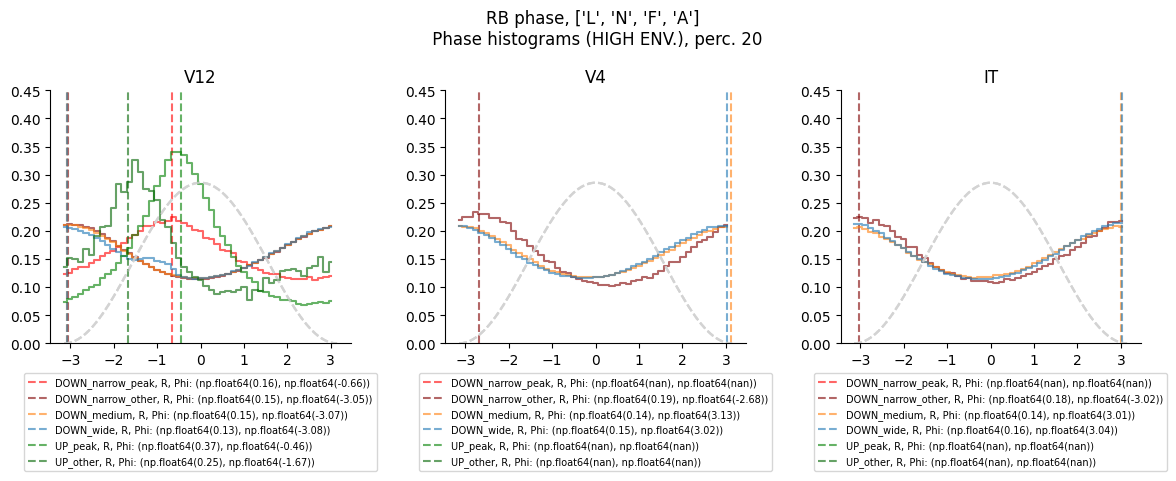

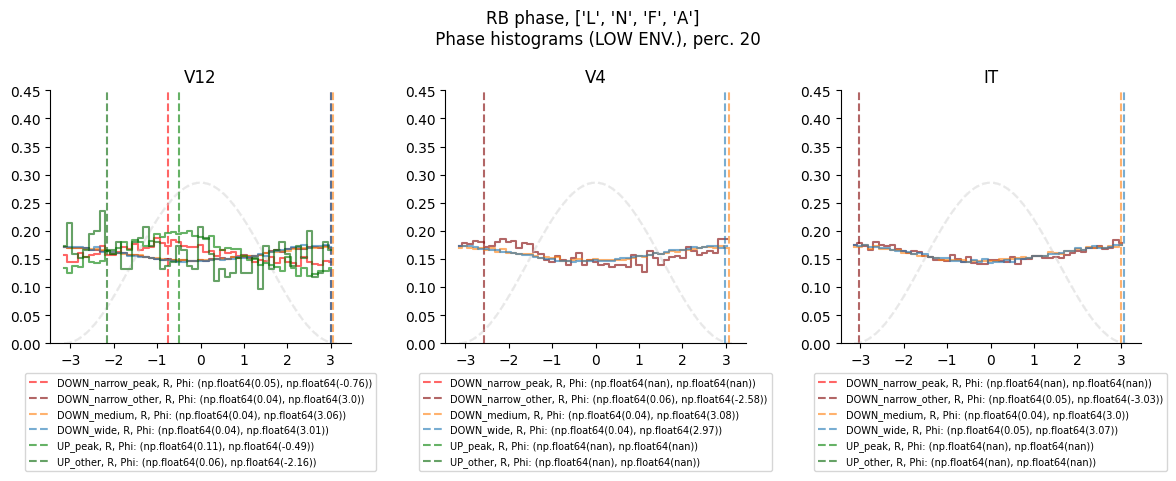

In [11]:
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=20,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


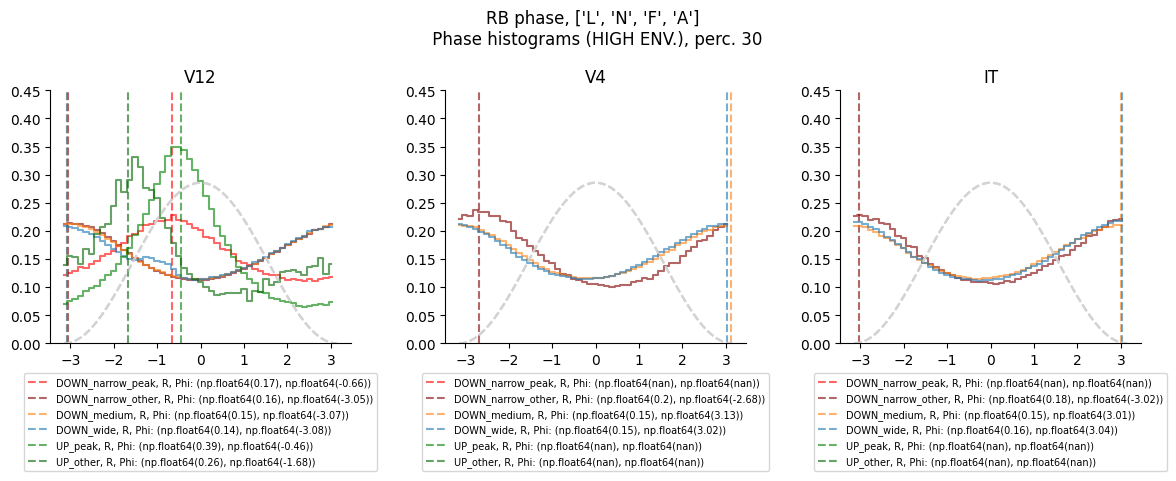

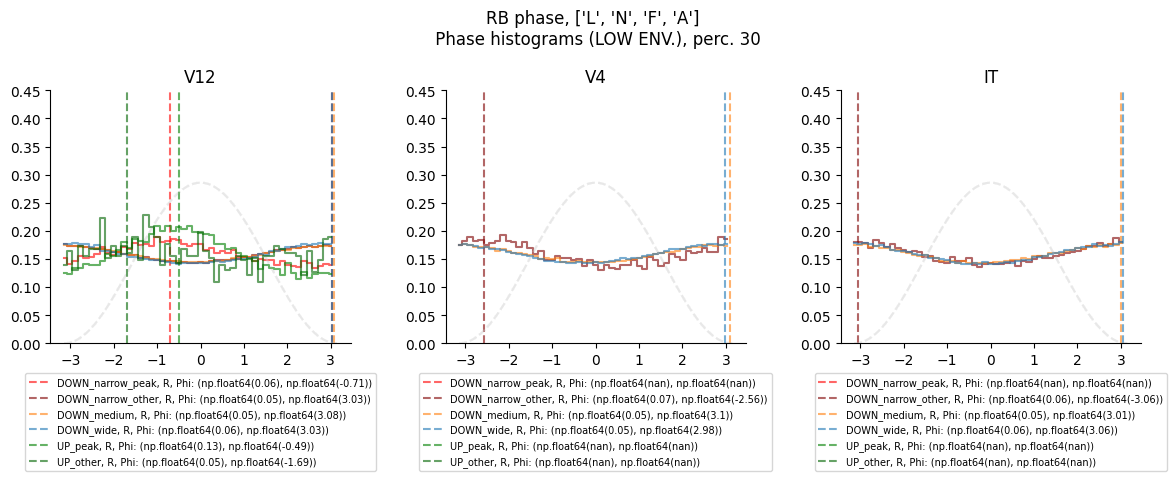

In [12]:
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=30,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


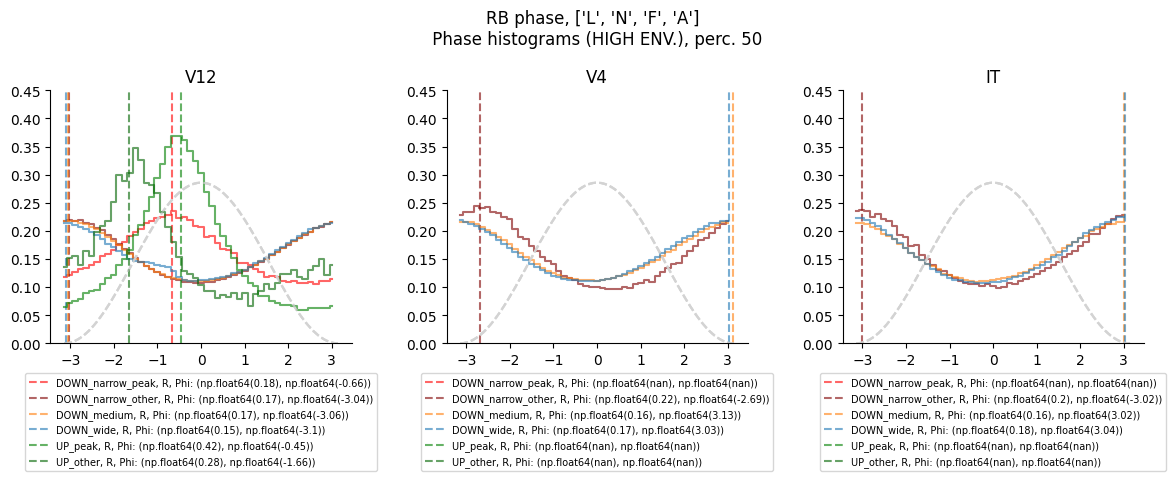

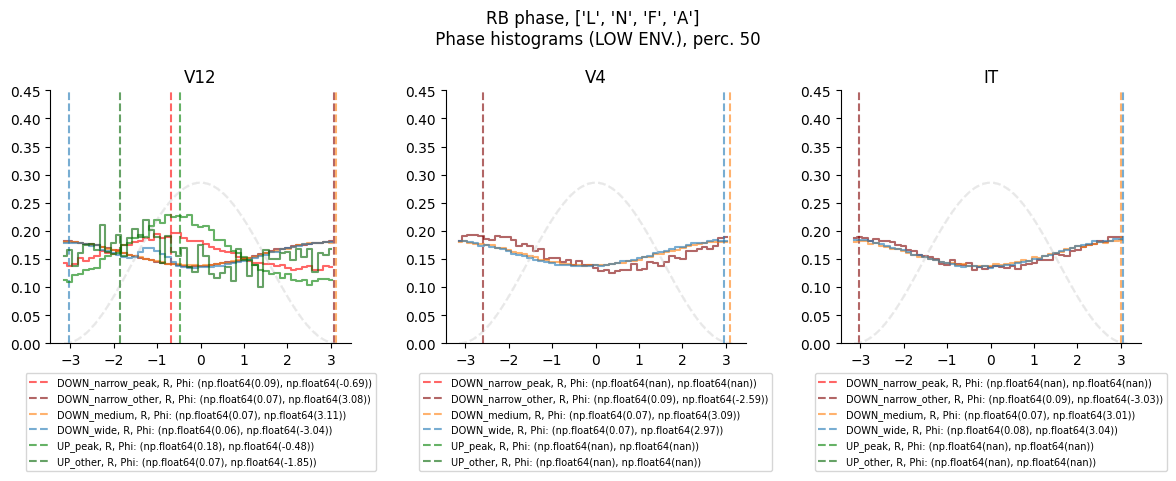

In [13]:
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


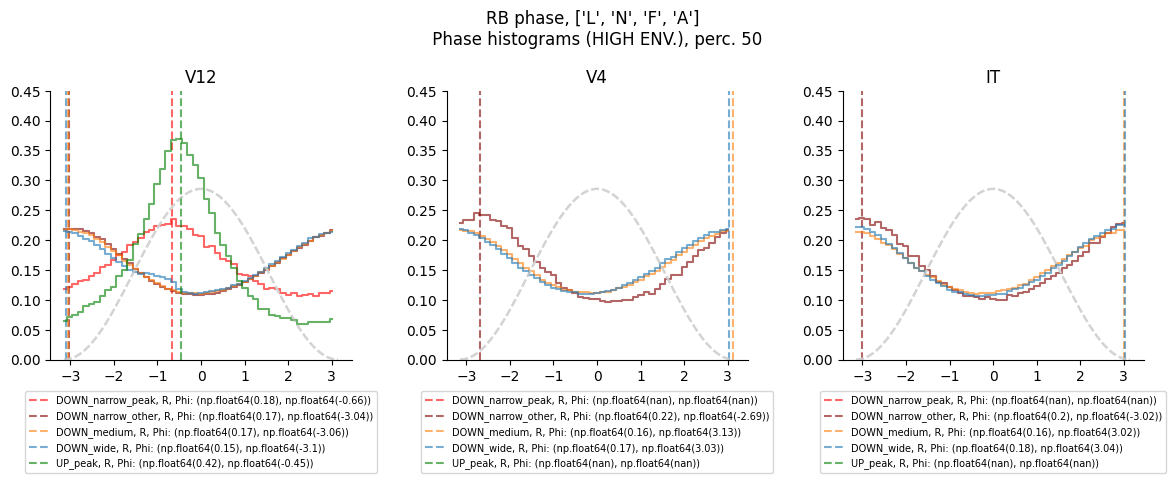

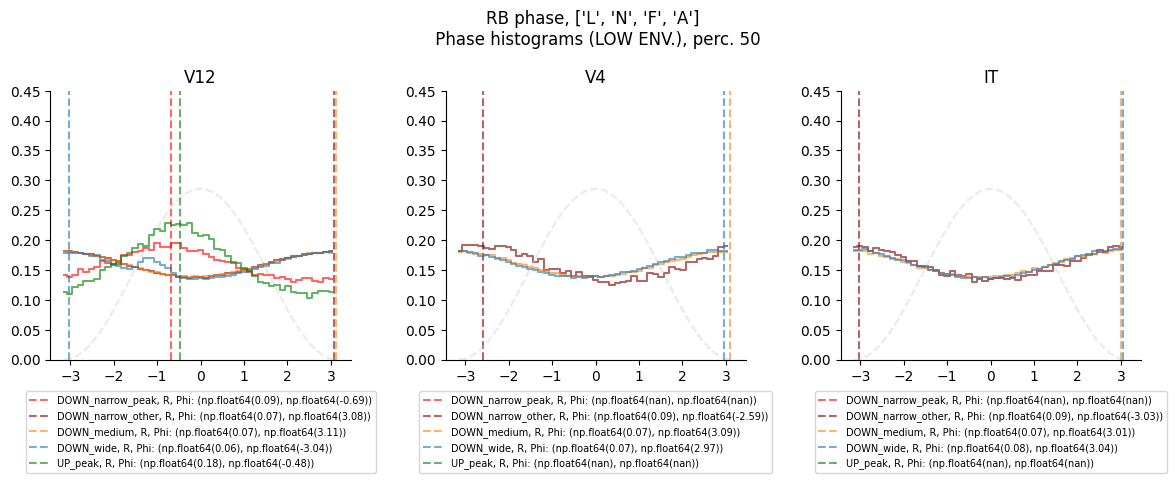

In [14]:
#### MEDIAN, NO DARK GREEN CELLS PLOTTED, CNS POSTER
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES[:-1],class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


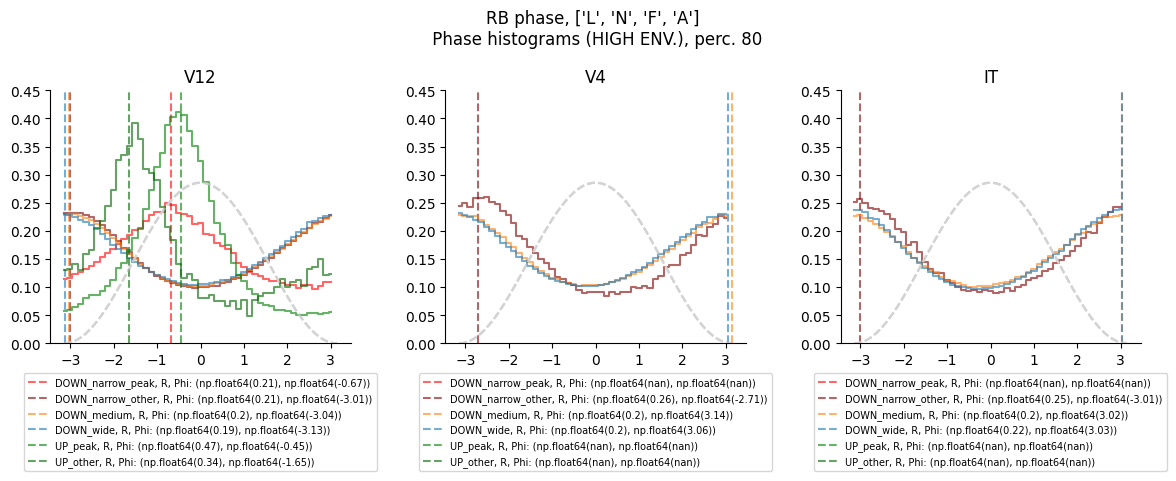

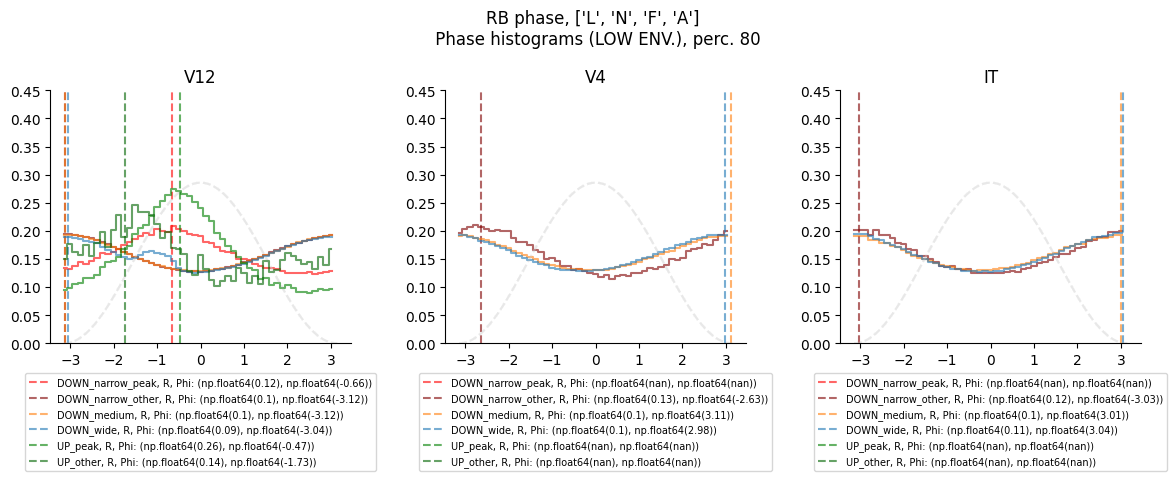

In [15]:
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=80,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


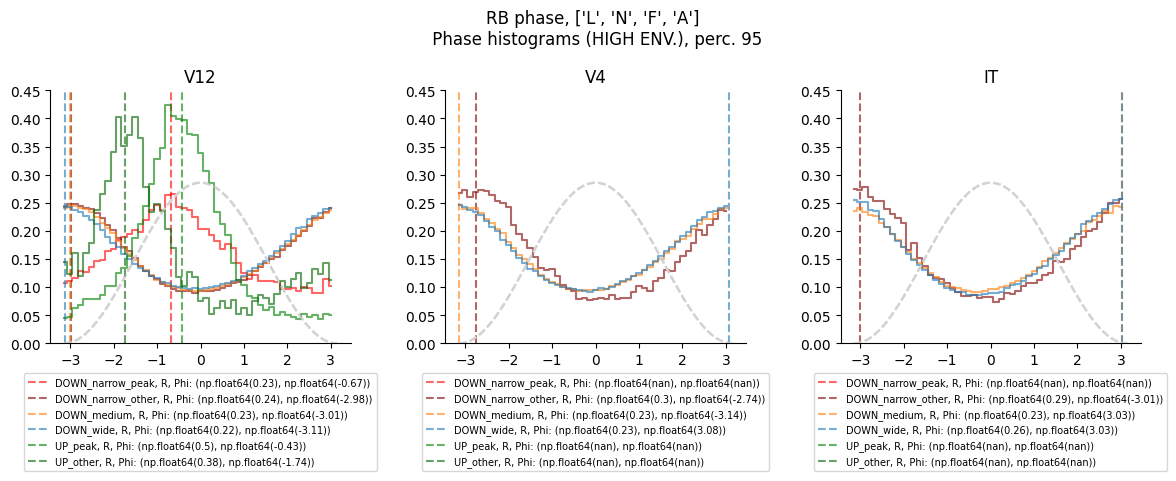

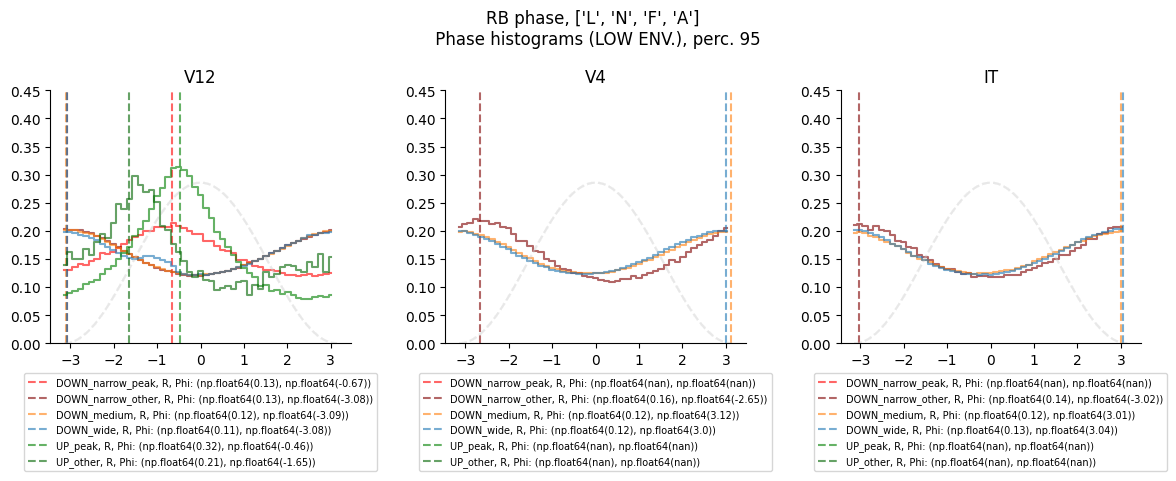

In [16]:
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=95,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}',y_max=0.45)

## Plotting - phase locking, only selective cells

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


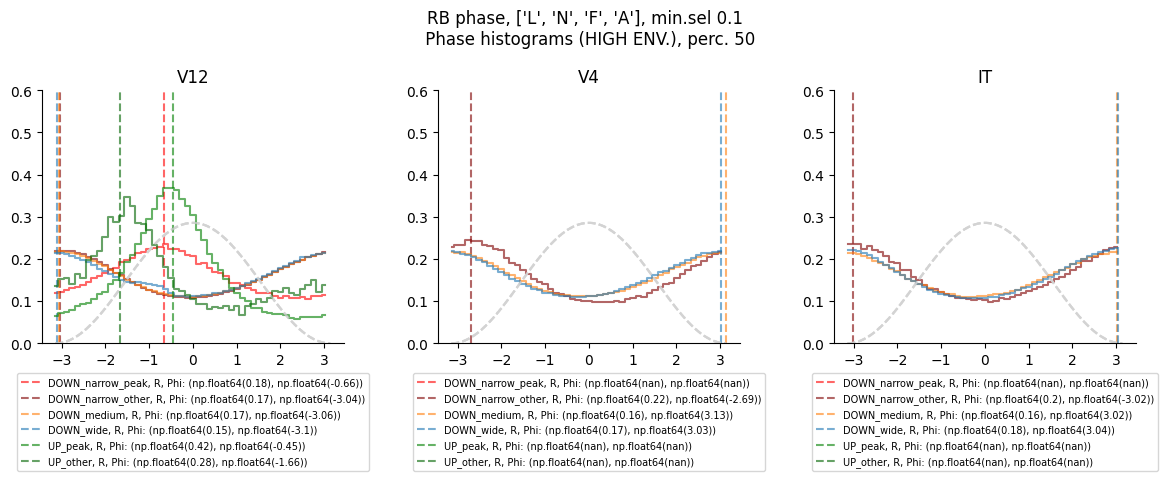

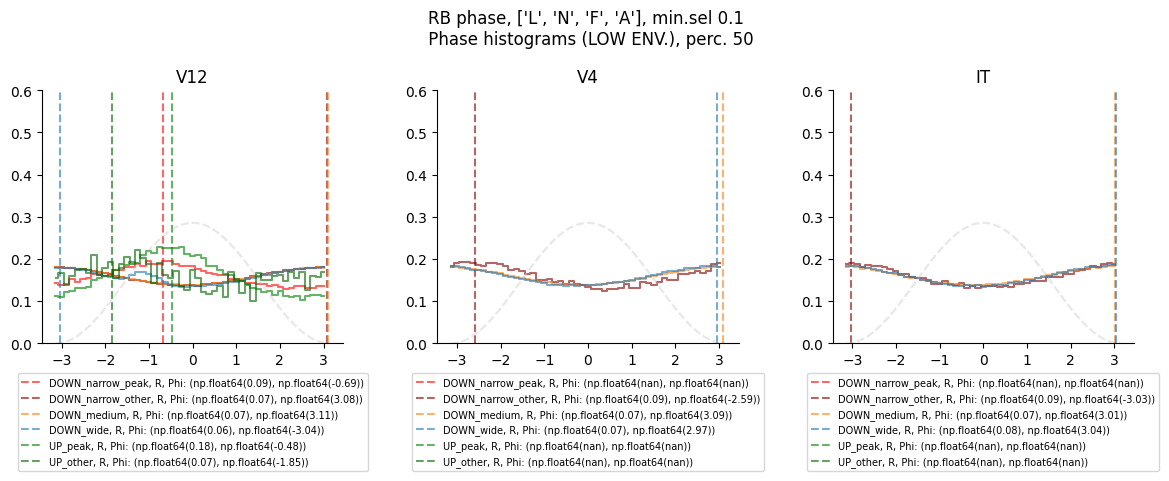

In [17]:
MIN_SEL = 0.1
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}, min.sel {MIN_SEL}',y_max=0.6,min_selectivity=MIN_SEL)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


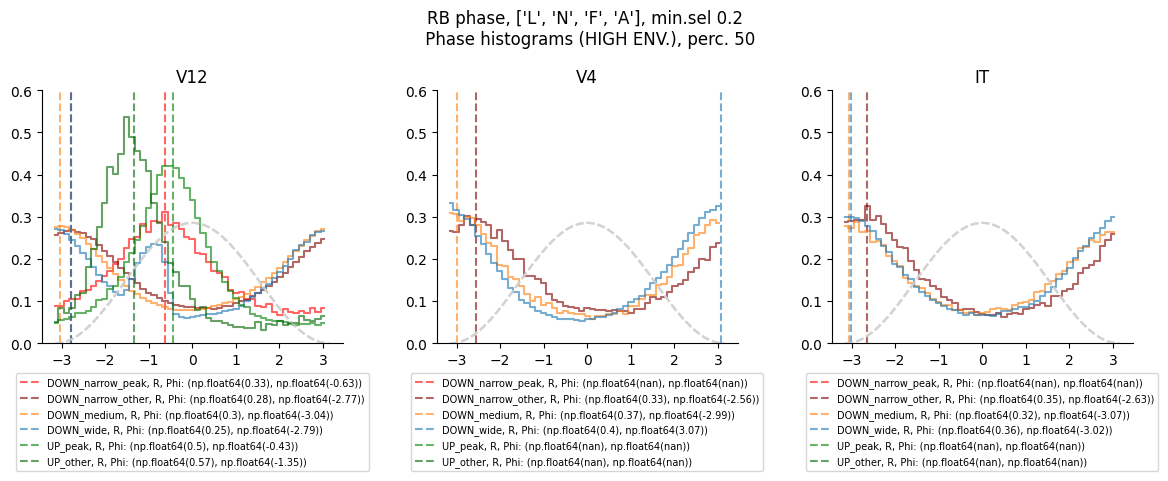

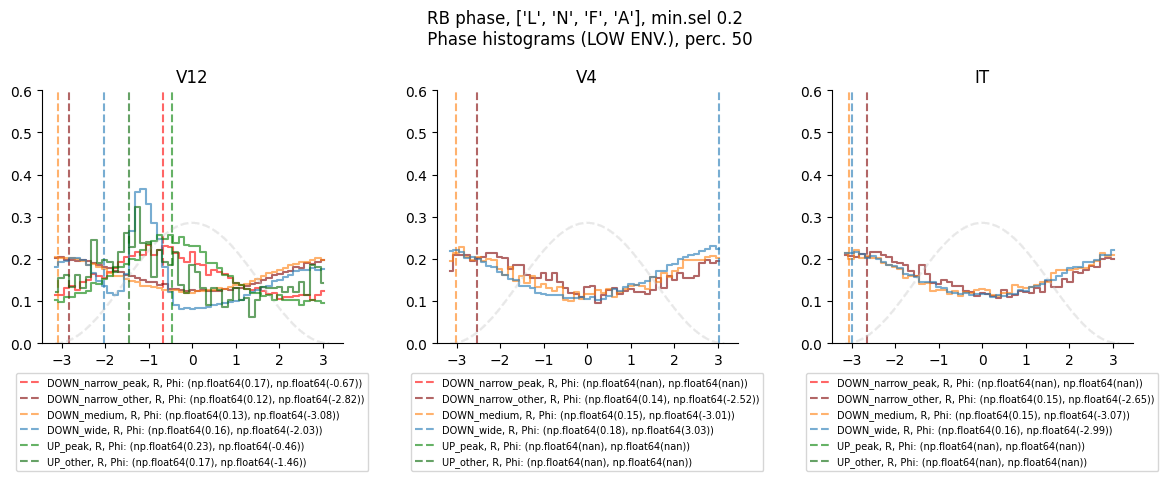

In [18]:
MIN_SEL = 0.2
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}, min.sel {MIN_SEL}',y_max=0.6,min_selectivity=MIN_SEL)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


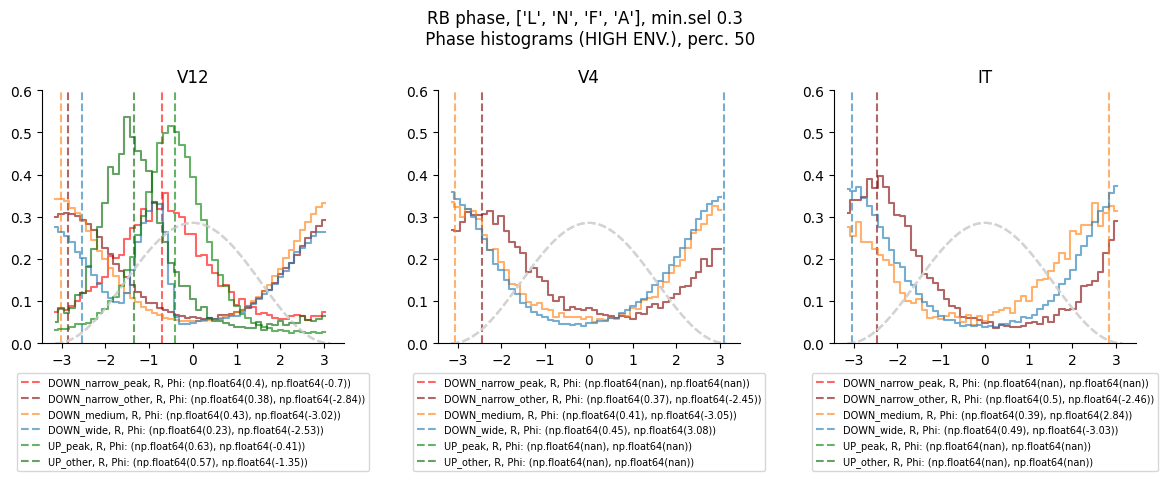

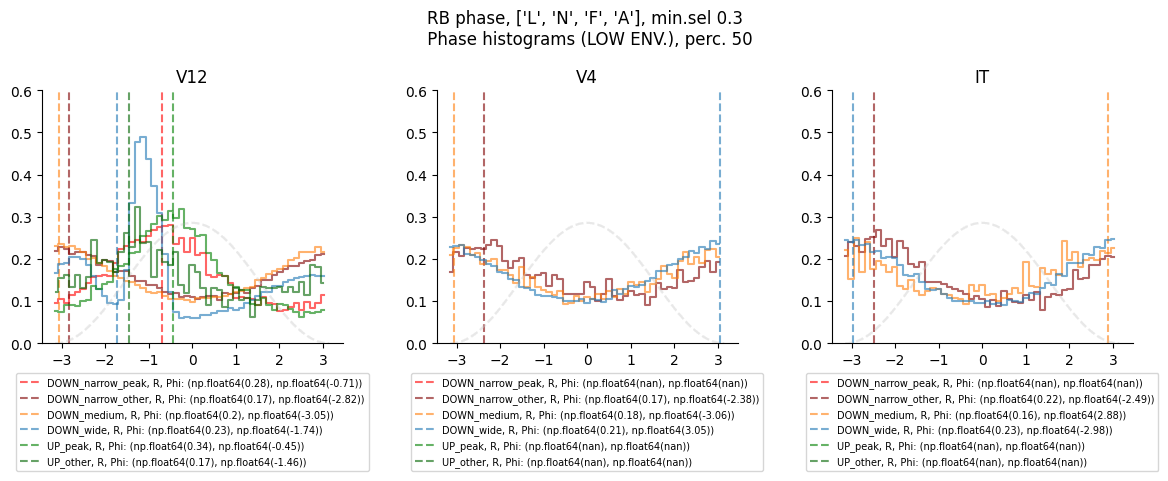

In [19]:
MIN_SEL = 0.3
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}, min.sel {MIN_SEL}',y_max=0.6,min_selectivity=MIN_SEL)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


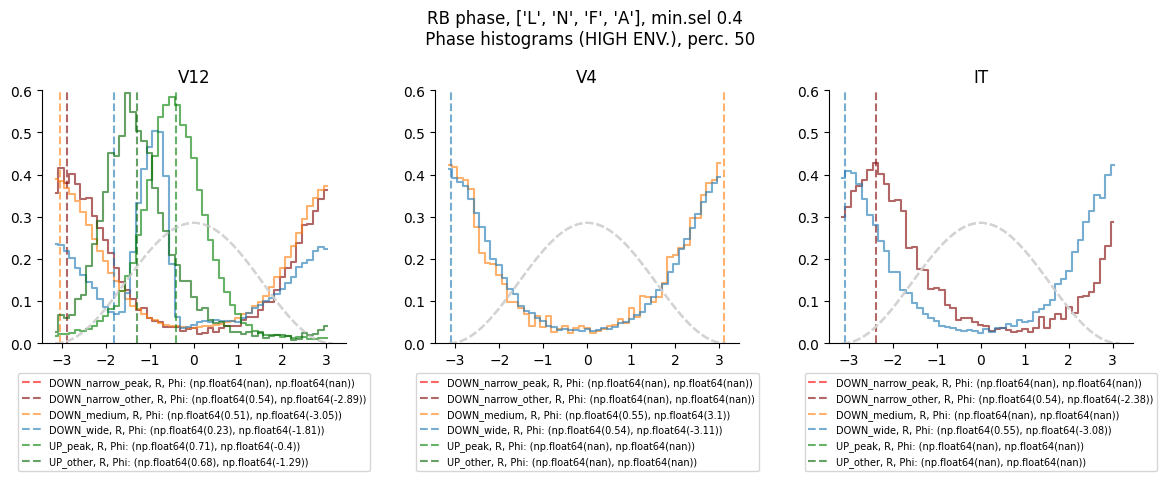

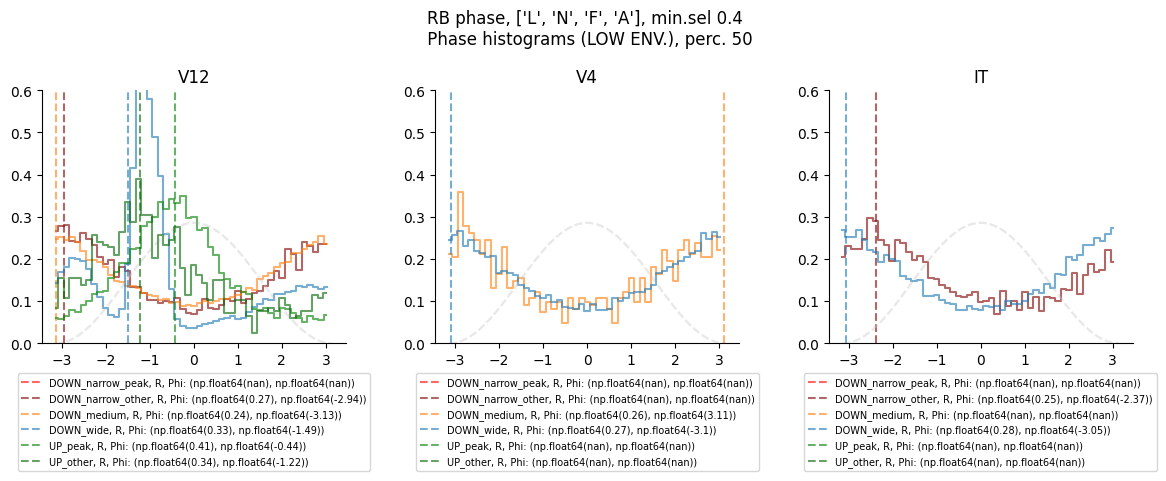

In [20]:
MIN_SEL = 0.4
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}, min.sel {MIN_SEL}',y_max=0.6,min_selectivity=MIN_SEL)

/home/studekat/virt_env/work/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/CSNG/studekat/ripple_band_project/code/functions_analysis.py:269: RuntimeWarning: invalid value encountered in divide
  bin_vals = bin_vals/np.sum(bin_vals) ### normalising histogram to density


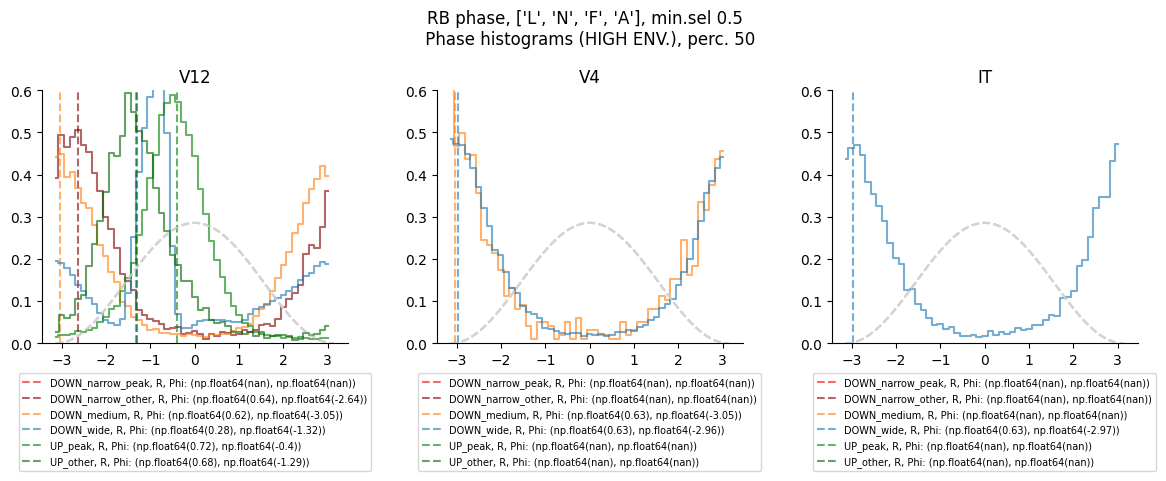

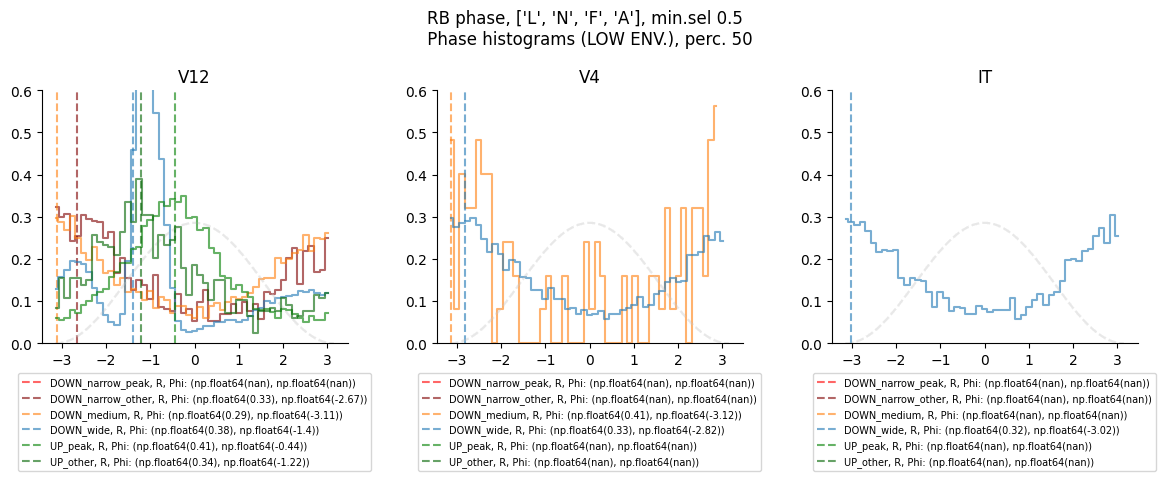

In [21]:
MIN_SEL = 0.5
plot_phases_percentile(df_merged,'list_phases','list_env',percentile=50,areas_list=AREAS_MERGED,
                           cell_types=FINAL_CLASSES,class_colors=CLASS_COLORS,
                           title=f'RB phase, {MONKEY_LIST}, min.sel {MIN_SEL}',y_max=0.6,min_selectivity=MIN_SEL)